# Settings

In [1]:
EXP_NO = 45
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [2]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [3]:
CV_THRESHOLD = None
PAST_EXPERIMENTS = tuple(exp_no for exp_no in range(29, 44 + 1))
PAST_EXPERIMENTS

(29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44)

# Library

In [4]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV, RidgeClassifierCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearnex import patch_sklearn

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from features import extract_representative_color_features, extract_representative_colors
from dataset import load_csvfiles, load_photofile
from folder import experiment_dir_of
from target import soring_date2target

In [5]:
pd.options.display.float_format = '{:.5f}'.format

In [6]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Prepare directory

In [7]:
output_dir = experiment_dir_of(EXP_NO)

In [8]:
output_dir

'..\\scripts\\..\\experiments\\exp045'

# Prepare logger

In [9]:
logger = getLogger(__name__)

In [10]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [11]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-22 16:20:15,268 - __main__ - INFO - Experiment no: 45
2021-07-22 16:20:15,269 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-22 16:20:15,270 - __main__ - INFO - SEED: 1
2021-07-22 16:20:15,271 - __main__ - INFO - REGRESSION: True


# Load csv files

In [12]:
SINCE = time.time()

In [13]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-22 16:20:15,300 - __main__ - DEBUG - Start loading csv files (0.017 seconds passed)
2021-07-22 16:20:15,329 - __main__ - DEBUG - Complete loading csv files (0.046 seconds passed)


In [14]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [15]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Feature engineering

Extract past experiments' prediction values for ensemble.

In [16]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [17]:
from typing import Tuple, Optional
def get_cv_prediction(experiments_no: Tuple[int],
                      cv_threshold: Optional[float] = None,
                      n_splits: int = 5,
                      log_func: Optional[callable] = print) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    pred_train, pred_valid, pred_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    # Process experiment result one by one
    for exp_no in experiments_no:
        # Get directory where results are stored
        output_dir = experiment_dir_of(exp_no, auto_make=False)
        if not os.path.isdir(output_dir):
            raise ValueError(exp_no, output_dir)

        # Check whether local cv is better than threshold.
        # If not, that experiment result will not be ensembled.
        # Skip this check if threshold is not given.
        if cv_threshold is not None:
            with open(os.path.join(output_dir, 'metrics.json'), 'r') as f:
                metrics = json.load(f)
            local_cv = metrics['valid_losses_avg']
            if local_cv > cv_threshold:
                log_func('Exclude experiment {} from ensemble, local_cv={:.5f}, threshold={:.5f}'. \
                         format(exp_no, local_cv, cv_threshold))
                continue

        # Load and cv result files, (fold1, fold2, ..., fold<n_splits>)
        pred_train_, pred_valid_, pred_test_ = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        for i in range(n_splits):
            num_fold = i + 1
            for fold in ('training', 'validation', 'test'):
                # Load prediction and merge into 1 dataframe
                pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_{fold}.csv'))
                if 'pred' not in pred_df:  # the task was classification
                    pred_df['pred'] = predict(pred_df['0'], pred_df['1'], pred_df['2'], pred_df['3'])
                pred_df['num_fold'] = num_fold
                pred_df = pred_df[['object_id', 'num_fold', 'pred']]
                if fold == 'training':
                    pred_train_ = pd.concat([pred_train_, pred_df])
                elif fold == 'validation':
                    pred_valid_ = pd.concat([pred_valid_, pred_df])
                elif fold == 'test':
                    pred_test_ = pd.concat([pred_test_, pred_df])

        pred_train_.rename(columns={'pred': f'exp{str(exp_no).zfill(3)}'}, inplace=True)
        pred_valid_.rename(columns={'pred': f'exp{str(exp_no).zfill(3)}'}, inplace=True)
        pred_test_.rename(columns={'pred': f'exp{str(exp_no).zfill(3)}'}, inplace=True)

        # Merge into 1 dataframe
        ## Training set
        if pred_train.shape[1] < 1:
            pred_train = pred_train_.copy()
        else:
            assert(pred_train.shape[0] == pred_train_.shape[0])
            pred_train = pd.merge(pred_train, pred_train_)
            assert(pred_train.shape[0] == pred_train_.shape[0])
        ## Validation set
        if pred_valid.shape[1] < 1:
            pred_valid = pred_valid_.copy()
        else:
            assert(pred_valid.shape[0] == pred_valid_.shape[0])
            pred_valid = pd.merge(pred_valid, pred_valid_)
            assert(pred_valid.shape[0] == pred_valid_.shape[0])
        ## Test set
        if pred_test.shape[1] < 1:
            pred_test = pred_test_.copy()
        else:
            assert(pred_test.shape[0] == pred_test_.shape[0])
            pred_test = pd.merge(pred_test, pred_test_)
            assert(pred_test.shape[0] == pred_test_.shape[0])

        log_func('Experiment {}: join into ensemble'.format(exp_no))

    return (pred_train.set_index('object_id'), pred_valid.set_index('object_id'), pred_test.set_index('object_id'))

In [18]:
# Get predictions of weak learner
pred_train_weak_learner, pred_valid_weak_learner, pred_test_weak_learner = get_cv_prediction(PAST_EXPERIMENTS, CV_THRESHOLD)

Experiment 29: join into ensemble
Experiment 30: join into ensemble
Experiment 31: join into ensemble
Experiment 32: join into ensemble
Experiment 33: join into ensemble
Experiment 34: join into ensemble
Experiment 35: join into ensemble
Experiment 36: join into ensemble
Experiment 37: join into ensemble
Experiment 38: join into ensemble
Experiment 39: join into ensemble
Experiment 40: join into ensemble
Experiment 41: join into ensemble
Experiment 42: join into ensemble
Experiment 43: join into ensemble
Experiment 44: join into ensemble


# Cross validation

In [19]:
train.set_index('object_id', inplace=True)

In [20]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    X_train = pred_train_weak_learner.loc[train_object_ids].query(f'num_fold == {num_fold}').drop(columns=['num_fold'])
    y_train = train.loc[train_object_ids, TARGET].values
    X_valid = pred_valid_weak_learner.loc[valid_object_ids].query(f'num_fold == {num_fold}').drop(columns=['num_fold'])
    y_valid = train.loc[valid_object_ids, TARGET].values
    X_test = pred_test_weak_learner.query(f'num_fold == {num_fold}').drop(columns=['num_fold'])
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 50.)) if REGRESSION \
                else RidgeClassifierCV(alphas=(0.01, 0.1, 1.0, 10.0, 50.), class_weight='balanced')
    estimator.fit(X_train, y_train)
    
    ## Save coefficients
    coef_df = pd.DataFrame(data=estimator.coef_)
    if REGRESSION:
        coef_df.index = X_train.columns
        coef_df.columns = ['coef']
    else:
        coef_df.columns = X_train.columns
    coef_df.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_coefficients.csv'))
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_test = pd.DataFrame(data=estimator.predict(X_test), columns=['pred'])
    else:
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = X_test.index.values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'wb') as f:
        pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, X_train, X_valid, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-22 16:20:18,707 - __main__ - DEBUG - Start fold 1 (3.424 seconds passed)
2021-07-22 16:20:18,742 - __main__ - DEBUG - Start training model (3.459 seconds passed)
2021-07-22 16:20:18,942 - __main__ - DEBUG - Complete training (3.658 seconds passed)
2021-07-22 16:20:18,964 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp045\cv_fold1_training.csv (3.681 seconds passed)
2021-07-22 16:20:18,984 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp045\cv_fold1_validation.csv (3.700 seconds passed)
2021-07-22 16:20:19,006 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp045\cv_fold1_test.csv (3.722 seconds passed)
2021-07-22 16:20:19,008 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp045\cv_fold1_model.pkl (3.724 seconds passed)
2021-07-22 16:20:19,077 - __main__ - DEBUG - Complete fold 1 (3.789 seconds passed)
2021-07-22 16:20:19,077 - __main__ - DEBUG - Start fold 2 (3.794 seconds passed)
2021-07-22 16:20:1

# Evaluation

In [21]:
rmse = partial(mean_squared_error, squared=False)

In [22]:
metrics = defaultdict(list)

## Training set

In [23]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    metrics['train_losses'].append(loss)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

2021-07-22 16:20:19,778 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-22 16:20:19,798 - __main__ - DEBUG - Loss: 7.152992870933078e-05
2021-07-22 16:20:19,799 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-22 16:20:19,816 - __main__ - DEBUG - Loss: 9.05893144026725e-05
2021-07-22 16:20:19,817 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-22 16:20:19,837 - __main__ - DEBUG - Loss: 0.00028753802772385186
2021-07-22 16:20:19,838 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-22 16:20:19,853 - __main__ - DEBUG - Loss: 8.898544690420338e-05
2021-07-22 16:20:19,854 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-22 16:20:19,874 - __main__ - DEBUG - Loss: 0.0004392649657715829


In [24]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,0.79989,1
00309fb1ef05416f9c1f,2.39999,3
003a1562e97f79ba96dc,2.39993,3
004890880e8e7431147b,1.60009,2
00718c32602425f504c1,2.39998,3
...,...,...
ffa3259fff8e6f3818a1,2.39998,3
ffd4d361756587883e48,0.79992,1
ffd794b7b311b7b7fd92,1.60007,2


In [25]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
logger.info('Training loss: {}'.format(loss))

2021-07-22 16:20:19,916 - __main__ - INFO - Training loss: 0.4086447407128876


In [26]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-22 16:20:19,940 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp045\prediction_train.csv


## Validation set

In [27]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    metrics['valid_losses'].append(loss)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

2021-07-22 16:20:19,966 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-22 16:20:19,982 - __main__ - DEBUG - Loss: 1.0036110206839985
2021-07-22 16:20:19,983 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-22 16:20:19,997 - __main__ - DEBUG - Loss: 1.022823426721264
2021-07-22 16:20:19,998 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-22 16:20:20,014 - __main__ - DEBUG - Loss: 1.067679585076022
2021-07-22 16:20:20,015 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-22 16:20:20,029 - __main__ - DEBUG - Loss: 1.0269315472104368
2021-07-22 16:20:20,030 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-22 16:20:20,046 - __main__ - DEBUG - Loss: 0.9636097827840651


In [28]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.39959,1
00309fb1ef05416f9c1f,0.20068,3
003a1562e97f79ba96dc,0.59970,3
004890880e8e7431147b,0.39981,2
00718c32602425f504c1,0.58757,3
...,...,...
ffa3259fff8e6f3818a1,0.59933,3
ffd4d361756587883e48,0.19999,1
ffd794b7b311b7b7fd92,0.39999,2


In [29]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
logger.info('Validatino loss: {}'.format(loss))

2021-07-22 16:20:20,093 - __main__ - INFO - Validatino loss: 1.6859904539273431


In [30]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-22 16:20:20,118 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp045\prediction_valid.csv


In [31]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-22 16:20:20,140 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp045\metrics.json


# Prediction

In [32]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [33]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.19267
000bd5e82eb22f199f44,2.01956
0015f44de1854f617516,1.99871
00388a678879ba1efa27,2.39583
005e1e7c6496902d23f3,1.57067
...,...
ffbe65ad399b632dcbd0,2.97557
ffd7b2d646c0320c311a,1.97608
ffdb93ede17d4501e530,2.19835


In [34]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.19267
1,2.01956
2,1.99871
3,2.39583
4,1.57067
...,...
5914,2.97557
5915,1.97608
5916,2.19835
5917,1.81539


In [35]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [36]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-22 16:20:20,336 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp045\045_submission.csv


2021-07-22 16:20:20,497 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp045\prediction.png


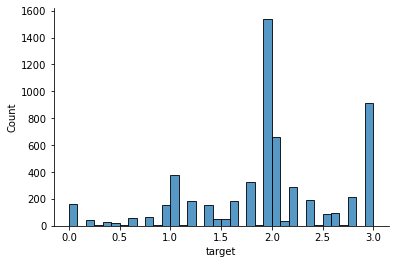

In [37]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [38]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-22 16:20:20,622 - __main__ - DEBUG - Complete (5.339 seconds passed)
